In [20]:
from __future__ import division
import numpy as np
import sympy as sym
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style('whitegrid')
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

import plotly           # 3d plots required being connected to the internet and a credentials file
import plotly.plotly as py
from plotly.graph_objs import *

%matplotlib inline

# Finding $k^{*}(x,y,l,r,params)$

The purpose of this notebook is to find a solution to a problem that arises when solving for the model with capital, for ceratin parameter combinations.

**Note:** 3d plots required being connected to the internet and a [plotly credentials file](https://plot.ly/python/user-guide/#Step-6)

## 1. Solving the cubic equation

The production function is:
$$rA\kappa(\eta(k)^{\rho} + (1 -\eta)(l^{x}y/r)^{\rho})^{\gamma/\rho} $$

Differentiating this function with respect o $k$ leads us to the first order condition for the optimal $k^*$:

$$rA\kappa\eta\gamma k^{\rho-1}(\eta(k)^{\rho} + (1 -\eta)(l^{x}y/r)^{\rho})^{(\gamma/\rho)-1}  - R = 0 $$

We can rename $K = k^{1/4}$, subsitute $\rho=0.25$ and $\gamma=0.5$ and obtain a thrid degree polynomial in $K$:

$$rA\kappa\eta(\eta K + (1 -\eta)((l/r)^{x}y)^{\rho}) - 2 R K^{3} = 0$$

Rearranging we get ot the cubic euqation we are trying to solve:

$$- 2 R K^{3} + rA\kappa\eta^{2} K + rA\kappa\eta(1 -\eta)((l/r)^{x}y)^{0.25}  = 0$$

Which is a *depressed cubic*, as there is no term going with $K^2$.

In [21]:
## Setting the parameters of the model (calibrated values)
R, rho, gamma, eta, L, A, kapa = sym.var('R, rho, gamma, eta, L, A, kapa')
### Defining variables ###
k, x, y, l, r = sym.var('k, x, y, l, r')

## Defining auxiliary functions a, c, d ##
a = -2*R
c = r*A*kapa*(eta**2)
d = r*A*kapa*eta*(1-eta)*(y*(l/r)**x)**(0.25)
K = sym.var('K')

## Defining the polynomial to solve ##
pol_K = K**3*a + K*c + d
polik = sym.lambdify((K,x,y,l,r,A,kapa,eta,R),pol_K)

There are several ways of solving this equation, but I'm going to focus in the trigonometric solution. This is because the standard *discriminant* way that was initially suggested gives trouble to the computer when fed into the solver, as it involves raising numbers to fractional negative powers. In constrast, trigonometric functions are easily differentiable.

From [wikipedia](https://en.wikipedia.org/wiki/Cubic_function#Trigonometric_.28and_hyperbolic.29_method), the first step is to arange our equation in this way:

<img src='https://upload.wikimedia.org/math/d/c/0/dc09d3c3aeb105f965ae57d0853b2456.png'>

Which is fairly easy as we already ahve a depressed cubic. Our $p$ and $q$ functions are:

$$p = -(\eta^2Ar\kappa)/(2R)$$

$$q = -(\eta(1-\eta)Ar\kappa(y(l/r)^x)^{(1/4)})/(2R)$$

Notice that $p$ does **not** depend on the value of any variable $(x,y,l)$, whereas $q$ does.

In [22]:
## Defining auxiliary functions p, q ##

p = -(eta**2*A*r*kapa)/(2*R)
q = -(eta*(1-eta)*kapa*r*A*(y*(l/r)**x)**(1/4))/(2*R)

The next step is to check how many real roots our cubic has. This depends on the values of $p$ and $q$:

- Case 1. If $p<0$ and $4p^3+27q^2>0$, then we have ***1 real root only***.


- Case 2. If $p>0$, then we also have ***1 real root only***.


- Case 3. If $p<0$ and $4p^3+27q^2<=0$ we have ***3 real roots***.

Case 2 is never going to happen for the ppor country, as $p$ is **always** negative. But we can be sometimes in regions where we switch from case 1 to case 3.

The case of three real roots is the one that applies in the case of the Rich country. I have previously studied this case and found the root that maximizes profits.

Below I code these solutions, plus functions to determine, given paramters, the case that applies.

In [23]:
## The Roots: Hyperbolic approach ##

# CASE 1: In case p<0 and 4p^3+27q^2>0 we have one root:
hyper_root = 2 * (-p/3)**(0.5) * sym.cosh( (1/3)*sym.acosh( ((3*q)/(2*p)) * (-3/p)**(0.5) ) )

# CASE 2: In case p>0, we also have one root:
hyper_root2 = -2* (p/3)**(0.5) * sym.sinh( (1/3)*sym.asinh( ((3*q)/(2*p)) * (3/p)**(0.5) ) )

# CASE 3: In case p<0 and 4p^3+27q^2<=0 we have three real roots, of which the biggest is:
root_zero = (2*(-p/3)**(0.5))*sym.cos( (1/3)*sym.acos( ((3*q)/(2*p)) * (-3/p)**(1/2) ) )


In [24]:
# Lambdifying the roots ##
HRt = sym.lambdify((x,y,l,r,A,kapa,eta,R), hyper_root)
HRt2 = sym.lambdify((x,y,l,r,A,kapa,eta,R), hyper_root2)
Rt0 = sym.lambdify((x,y,l,r,A,kapa,eta,R), root_zero)

In [25]:
## Trigonometric condition function ##

def trig_condition(x,y,l,r,A,kappa,eta,R):
    '''
    Condition for three real roots
    
    Input: A series of model parameters and values (x,y,l,r,A,kappa,eta,R)
    
    Output: An interger for the case in which we are in (see above)
    '''
    p = -(eta**2*A*r*kappa)/(2*R)
    q = -(eta*(1-eta)*kappa*r*A*(y*(l/r)**x)**(1/4))/(2*R)
    pq = 4*p**3+27*q**2
    if p<0 and pq<=0:
        return 3
    elif p<0 and pq>0:
        return 1
    elif p>0:
        return 2


In [26]:
## Integrated function for case 1 and 3 ##

def My_k_star(x,y,l,r,A,kappa,eta,R):
    '''
    Function that returns the root that applies 
    depending on the parameters we have (input).
    
    Input: A series of model parameters and values (x,y,l,r,A,kappa,eta,R)
    
    Output: Tuple with
            - a float with the value of the root.
            - an interger with the case.
    '''
    if trig_condition(x,y,l,r,A,kappa,eta,R) == 1:
        return (HRt(x,y,l,r,A,kappa,eta,R),1)
    elif trig_condition(x,y,l,r,A,kappa,eta,R) == 3:
        return (Rt0(x,y,l,r,A,kappa,eta,R),3)

In [27]:
## Calculating the result for different ys ##

y_range=np.linspace(1e-3,10,10000)

k_stars1 = []
y1 = []
y3 = []
k_stars3 = []

## For a certain range of y and parameters of the poor country ##
for i in y_range:
    kt, case = My_k_star(1,i,i,1.0,0.5105,1.0,0.89,0.83684)
    if case==1:
        k_stars1.append(kt**4)    # Raising to the 4th power for k
        y1.append(i)
    elif case==3:
        k_stars3.append(kt**4)    # Raising to the 4th power for k
        y3.append(i)

In [28]:
## Calculating the result for different ls ##

l_range=np.linspace(1e-3,5.0,10000)

kl_stars1 = []
l1 = []
l3 = []
kl_stars3 = []

## For a certain range of y and parameters of the poor country ##
for i in l_range:
    kt, case = My_k_star(1,2,i,1.0,0.5105,1.0,0.89,0.83684)
    if case==1:
        kl_stars1.append(kt**4)
        l1.append(i)
    elif case==3:
        kl_stars3.append(kt**4)
        l3.append(i)

No kink either. This is good because this implies that the solution is differentiable, that is what we need for latter solving for the matching differential equations.

For replycaing R&A **we only need $l$ and $y$ to be free**: x is homogeneous (or almost) and the rest of the parameters are fixed for each country. As the developed country poses no problems so far, I'll focus in the poor country case.

Then this becomes a problem of fitting a surface $k^*(y,l)$.

## 2. Plotting a general solution to the cubic in 3d

In [12]:
# 1. Get the Grid
y3d = np.linspace(1.2,10.0,100)
l3d = np.linspace(0.01,10.0,100)

k1r = []
k3r = []
y1r = []
y3r = []
l1r = []
l3r = []

# 1.1 Different points for different roots 
for y in y3d:
    for l in l3d:
        kt, case = My_k_star(1,y,l,1.0,0.5105,1.0,0.89,0.83684)
        if case==1:
            k1r.append(kt**4)
            l1r.append(l)
            y1r.append(y)
        elif case==3:
            k3r.append(kt**4)
            l3r.append(l)
            y3r.append(y)

k1r = np.array(k1r)
k3r = np.array(k3r)
y1r = np.array(y1r)
y3r = np.array(y3r)
l1r = np.array(l1r)
l3r = np.array(l3r)

In [13]:
# 1.2 Unique grid
ronda = 0
for y in y3d:
    k_line = np.empty(0)
    for l in l3d:
        kt, case = My_k_star(1,y,l,1.0,0.5105,1.0,0.89,0.83684)
        k_line = np.hstack((k_line,kt**4))
    if ronda == 0:
        k_array = k_line
        k_flat = k_line
        ronda = 42
    else:
        k_array = np.vstack((k_array,k_line))
        k_flat = np.hstack((k_flat,k_line))

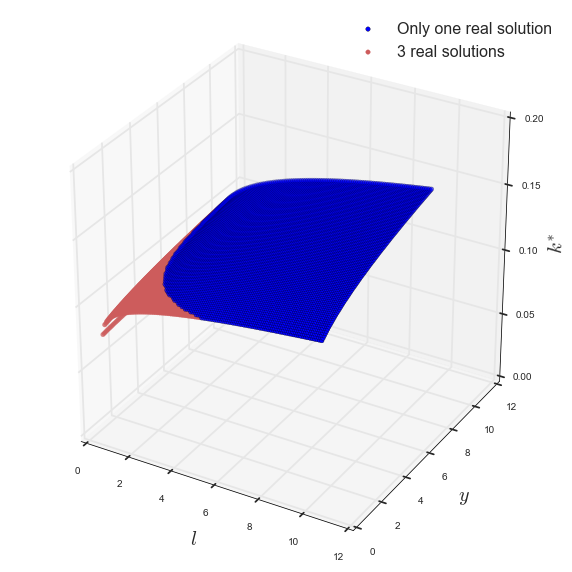

In [14]:
# 2.1 Different colors for different roots

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(l1r, y1r, zs=k1r, label='Only one real solution')
ax.scatter(l3r, y3r, zs=k3r, color='indianred', label='3 real solutions')
ax.set_ylim(0,12)
ax.set_xlim(0,12)
ax.set_zlim(0,0.2)
ax.set_xlabel('$l$', fontsize=20)
ax.set_ylabel('$y$', fontsize=20)
ax.set_zlabel('$k^*$', fontsize=20)
ax.legend(fontsize=16)

plt.show()

In [48]:
x_array[990000:1000000]

array([ 10.,  10.,  10., ...,  10.,  10.,  10.])

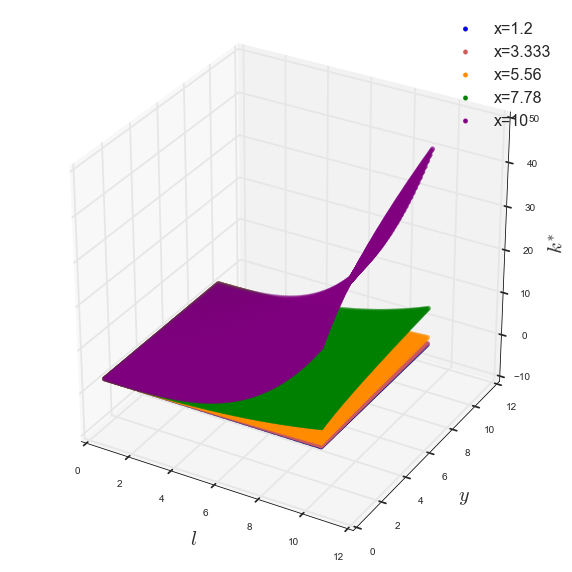

In [49]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(l_array[:10000], y_array[:10000], zs=k_array[:10000], label='x=1.2')
ax.scatter(l_array[240000:250000], y_array[240000:250000], zs=k_array[240000:250000], label='x=3.333',color='indianred')
ax.scatter(l_array[490000:500000], y_array[490000:500000], zs=k_array[490000:500000], label='x=5.56',color='darkorange')
ax.scatter(l_array[740000:750000], y_array[740000:750000], zs=k_array[740000:750000], label='x=7.78',color='green')
ax.scatter(l_array[990000:1000000], y_array[990000:1000000], zs=k_array[990000:1000000], label='x=10',color='purple')
ax.set_ylim(0,12)
ax.set_xlim(0,12)
#ax.set_zlim(0,0.2)
ax.set_xlabel('$l$', fontsize=20)
ax.set_ylabel('$y$', fontsize=20)
ax.set_zlabel('$k^*$', fontsize=20)
ax.legend(fontsize=16)

plt.show()

In [29]:
y3d = np.linspace(1.2,10.0,100)
l3d = np.linspace(0.01,10.0,100)
x3d = np.linspace(1.2,10.0,100)

k1r = []
k3r = []
y1r = []
y3r = []
l1r = []
l3r = []
x1r = []
x3r = []

# 1.1 Different points for different roots 
for x in x3d:
    for y in y3d:
        for l in l3d:
            kt, case = My_k_star(x,y,l,1.0,0.5105,1.0,0.89,0.83684)
            if case==1:
                k1r.append(kt**4)
                l1r.append(l)
                y1r.append(y)
                x1r.append(x)
            elif case==3:
                k3r.append(kt**4)
                l3r.append(l)
                y3r.append(y)
                x3r.append(x)

k1r = np.array(k1r)
k3r = np.array(k3r)
y1r = np.array(y1r)
y3r = np.array(y3r)
l1r = np.array(l1r)
l3r = np.array(l3r)
x1r = np.array(x1r)
x3r = np.array(x3r)

In [162]:
x1list = []
x1buff=0
for i in range(len(x1r)-1):
    x1buff+=1
    if x1r[i]!=x1r[i+1]:
        x1list.append(x1buff)
        x1buff =0
x1list.append(x1buff)

x3list = []
x3buff=0
for i in range(len(x3r)-1):
    x3buff+=1
    if x3r[i]!=x3r[i+1]:
        x3list.append(x3buff)
        x3buff =0
x3list.append(x1buff)

In [174]:
len(x3d)

100

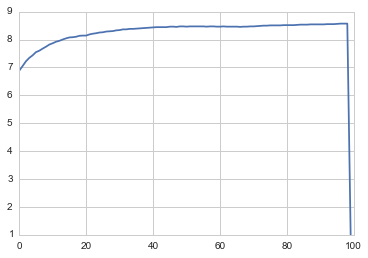

In [177]:
plt.plot(np.array(x1list)/np.array(x3list))
plt.show()

In [105]:
print "Ratio of 3 root case vs 1 root case:", len(x3r)/len(x1r)

Ratio of 3 root case vs 1 root case: 0.120597592284


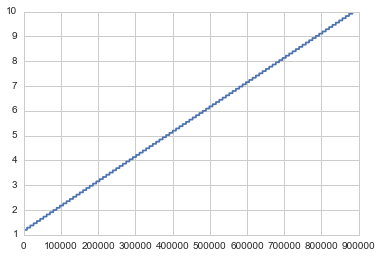

In [151]:
#plt.plot(x3r)
plt.plot(x1r)
plt.show()

In [30]:
# 1.2 Unique grid
k_array = []
x_array = []
y_array = []
l_array = []


for x in x3d:
    for y in y3d:       
        for l in l3d:
            k_array.append((My_k_star(x,y,l,1.0,0.5105,1.0,0.89,0.83684)[0])**4)
            x_array.append(x)
            y_array.append(y)
            l_array.append(l)
k_array = np.array(k_array)
x_array = np.array(x_array)
y_array = np.array(y_array)
l_array = np.array(l_array)

In [84]:
# Slicing
k_x0 = k_array[:100000]
k_x25 = k_array[240000:250000]
k_x50 = k_array[490000:500000]
k_x75 = k_array[740000:750000]
k_x100 = k_array[900000:1000000]

k3d_x0 = k_x0[0:100]
k3d_x25 = k_x25[0:100]
k3d_x50 = k_x50[0:100]
k3d_x75 = k_x75[0:100]
k3d_x100 = k_x100[0:100]

for i in range(100,10000,100):
    k3d_x0 = np.vstack((k3d_x0,k_x0[i:i+100]))
    k3d_x25 = np.vstack((k3d_x25,k_x25[i:i+100]))
    k3d_x50 = np.vstack((k3d_x50,k_x50[i:i+100]))
    k3d_x75 = np.vstack((k3d_x75,k_x75[i:i+100]))
    k3d_x100 = np.vstack((k3d_x100,k_x100[i:i+100]))

In [85]:
np.shape(k_x100)

(100000L,)

It seems that lower values of $l$ (land size) trigger the *3 real solutions case*, and this is specially tru for low values of $y$.

The plot below is interactive, but does not distinguish between roots. If you can't see the plot, click in the link below.

In [86]:
    
trace1 = Surface(z=k3d_x0, x=y3d, y=l3d)
trace2 = Surface(z=k3d_x25, x=y3d, y=l3d)   # link 1d numpy array of y coords
trace3 = Surface(z=k3d_x50, x=y3d, y=l3d) 
trace4 = Surface(z=k3d_x75, x=y3d, y=l3d) 
trace5 = Surface(z=k3d_x100, x=y3d, y=l3d) 

# Package the trace dictionary into a data object
data = Data([trace1, trace2, trace3, trace4, trace5])
# Package the trace dictionary into a data object

# Dictionary of style options for all axes

# Make a layout object
layout = Layout(title='k* for different xs', scene=Scene(xaxis=XAxis(title='y'),yaxis=YAxis(title='l'),zaxis=ZAxis(title='k*')))

# Make a figure object
fig = Figure(data=data, layout=layout)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='k_x')

[**CLICK HERE IF YOU CAN'T SEE THE PLOT**](https://plot.ly/~cris8a/34/k/)

Re-doing this fancy chart in two colours for each case would be great, but it seems that compared to the graph above, it is for blue areas that the  *3 real solutions case* is triggered.

## 3. Approximating $k^*$

Right now, I'm chosing a linear combination of polynomials in $l$ and $y$ with logarithms. There may be others, but it but hsi one is easily differentiable and pretty close.

I'm using a very simple least squares minimization to fit the function to the previous result - that is all the points spit by the two different solutions. In doing so I add some numerical error (also plotted).

In [90]:
from scipy.optimize import leastsq

In [145]:
## Setting up residual function ##
def res(params, kr, z, a, b):
    a0, a1, a2, b1, b2, ab1, ab2, a2b, ab22, c1, c2, c3, c4, xp1, xp3, xp4, xp6, xp7, xp8, xp9, xp10, xp11 = params
    return (xp1*z +  xp3*z*a + xp4*z*b + xp6*z*a**2 + xp7*z*b**2 + z*a*b*xp8 + xp9* np.exp(z) + xp10*np.log(z) + a0 + a1*a + a2*a**2+ b1*b + b2*b**2 + ab1*a*b + ab2*a*b**2 + a2b*a**2*b + ab22*a**2*b**2 + c1*np.exp(a) + c2*np.exp(b) + c3*np.log(a) + c4*np.log(b))*z*xp11 - kr 
p_opt = leastsq(res,  np.array([0, 0.075, -0.003125, 0.12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]), args=(k_array, x_array, y_array,l_array))

In [146]:
## Solution parameters ##
p_opt

(array([  1.39497073e-01,  -6.94083968e-03,   2.31383313e-03,
          1.59474996e-01,  -2.31276679e-02,  -1.34332285e-02,
          1.02252586e-03,   1.43806213e-04,  -4.04017794e-05,
          3.52115108e-08,   4.05574431e-06,   2.61743606e-02,
          7.88593056e-03,   2.18606826e-02,  -2.59212072e-04,
         -2.26439573e-02,  -2.46216740e-04,   3.52310950e-03,
          1.29356938e-03,   1.12921329e-05,  -1.76410577e-01,
          2.11054865e+00]), 1)

In [147]:
## Generating fitted values ##

# 1.2 Unique grid
k_fit = []
for x in x3d:
    for y in y3d:       
        for l in l3d:
            k_fit.append(res(p_opt[0], 0, x, y, l))
k_fit = np.array(k_fit)

In [148]:
## Mean of squared residuals ##
np.sum((k_fit-k_array)**2)/1e6

0.85338905713444557

In [142]:
# Slicing
kf_x0 = k_fit[:100000]
kf_x25 = k_fit[240000:250000]
kf_x50 = k_fit[490000:500000]
kf_x75 = k_fit[740000:750000]
kf_x100 = k_fit[900000:1000000]

k3df_x0 = kf_x0[0:100]
k3df_x25 = kf_x25[0:100]
k3df_x50 = kf_x50[0:100]
k3df_x75 = kf_x75[0:100]
k3df_x100 = kf_x100[0:100]

for i in range(100,10000,100):
    k3df_x0 = np.vstack((k3df_x0,kf_x0[i:i+100]))
    k3df_x25 = np.vstack((k3df_x25,kf_x25[i:i+100]))
    k3df_x50 = np.vstack((k3df_x50,kf_x50[i:i+100]))
    k3df_x75 = np.vstack((k3df_x75,kf_x75[i:i+100]))
    k3df_x100 = np.vstack((k3df_x100,kf_x100[i:i+100]))

The next plot shows the fitted values in green colors versus the real values in grey. If the fit was perfect, then you should not be able to see any green, as the surfaces would totally overlap.

In [143]:
trace1 = Surface(z=k3d_x25, x=y3d, y=l3d, colorscale='Greys')
trace2 = Surface(z=k3df_x25, x=y3d, y=l3d, colorscale='Greens')   # link 1d numpy array of y coords

# Package the trace dictionary into a data object
data = Data([trace1, trace2])

# Dictionary of style options for all axes

# Make a layout object
layout = Layout(title='Fitted k* x=1.2 ', scene=Scene(xaxis=XAxis(title='y'),yaxis=YAxis(title='l'),zaxis=ZAxis(title='k*')))

# Make a figure object
fig = Figure(data=data, layout=layout)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='fitted_k_x50')

[**CLICK HERE IF YOU CAN'T SEE THE PLOT**](https://plot.ly/~cris8a/38/fitted-k/)

Again: the greens are the fitted values, real values are in greys. Perfect fit would require seeing no green.

Finally, here is also a plot of the errors:

In [42]:
trace3 = Surface(z=k_fitted-k_array, x=l3d, y=y3d, colorscale='Portland')   # link 1d numpy array of y coords

# Package the trace dictionary into a data object
data = Data([trace3])

# Make a layout object
layout = Layout(title='Residual plot', scene=Scene(xaxis=XAxis(title='l'),yaxis=YAxis(title='y'),zaxis=ZAxis(title='k*') ))

# Make a figure object
fig = Figure(data=data, layout=layout)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='errors')

[**CLICK HERE IF YOU CAN'T SEE THE PLOT**](https://plot.ly/~cris8a/6/residual-plot/)

Fit is quite good, gets worse for low $l$. Hopefully these low levels are never chosen optimally. But that would be difficult to say, as optimal $l^*$ depends on this function that we are approximating. Land should be cheaper but we also expect smaller plots in developing countries.

Maybe try a hyperbolic function to fit this one? Maybe using a "switch" function such that when $4p^3+27q^2>0$ is equal to one and when $4p^3+27q^2<=0$ is 0? Will this non-differentiable function help?

## *...to be continued*